In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import datetime

import pyfolio as pf
from pyfolio import timeseries
import empyrical as ep

from statsmodels.stats.stattools import jarque_bera
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, gaussian_kde

C:\Users\maxru\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
#Functions
def daily_to_monthly(daily_series):
    monthly_series = daily_series.resample('M').agg(lambda x: (x+1).prod() - 1)
    return monthly_series

def daily_to_yearly(daily_series):
    yearly_series = daily_series.resample('Y').agg(lambda x: (x+1).prod() - 1)
    return yearly_series

def summary_statistics(returns, period = 'daily'):
    for i in returns:
        values = [i,returns[i].index[0], 
                   returns[i].index[-1], 
                   ep.annual_return(returns[i], period=period), 
                   ep.annual_volatility(returns[i], period=period),
                   stats.skew(returns[i], nan_policy = 'omit'),
                   stats.kurtosis(returns[i], nan_policy = 'omit'),
                   ep.sharpe_ratio(returns[i], period=period, risk_free = 0),
                   ep.sortino_ratio(returns[i], period=period),
                   ep.max_drawdown(returns[i]),
                   ep.tail_ratio(returns[i]),
                   timeseries.value_at_risk(returns[i], sigma = 2)]
        table.loc[len(table)] = values
    return table

#pf.create_returns_tear_sheet(FF_factor_return['Mkt-RF'])
#Means
#Geometric mean: stats.gmean()
#Harmonic mean: stats.hmean()

#Variances
#Range: np.ptp()
#Mean Absolute Deviation (MAD): 
#abs_dispersion = [np.abs(mu - x) for x in X]
#MAD = np.sum(abs_dispersion)/len(abs_dispersion)
#Semivariance: 
#lows = [e for e in X if e <= mu]
#semivar = np.sum( (lows - mu) ** 2 ) / len(lows)
#Semideviation: np.sqrt(semivar)

In [3]:
#Investment Universe
#Monthly Data
equities_MSCI = pd.read_csv('Equities_MSCI_Monthly_USD.csv', index_col = 0)

#Daily Data
world_indices = pd.read_csv('Equities_World_Indices_Daily.csv', index_col = 0)
equities_country_ETF = pd.read_csv('Equities_iShares_Country_ETF_Daily_USD.csv', index_col = 0)
FF_factor_return = pd.read_csv('Factors_Fama_French_Return_Daily_USD.csv', index_col = 0)
US_MSCI_factor = pd.read_csv('Factors_MSCI_US_ETF_Daily_USD.csv', index_col = 0)
sector = pd.read_csv("Sector_ETF_Daily_USD.csv", index_col = 0)
industry = pd.read_csv("Industry_ETF_Daily_USD.csv", index_col = 0)
treasury = pd.read_csv('Bonds_US_Treasury_Yields_Daily_USD.csv', index_col = 0)
bonds_US_IG = pd.read_csv('Bonds_US_IG_ETF_Daily_USD.csv', index_col = 0)
GSCI = pd.read_csv('Commodities_GSCI_Daily_USD.csv', index_col = 0)
commodities_energy = pd.read_csv('Commodities_Energy_Daily_USD.csv', index_col = 0)
commodities_metals = pd.read_csv('Commodities_Metals_Daily_USD.csv', index_col = 0)
commodities_agriculture = pd.read_csv('Commodities_Agriculture_Daily_USD.csv', index_col = 0)
BDI = pd.read_csv('Commmodities_Baltic_Dry_Daily_USD.csv', index_col = 0)
currency = pd.read_csv("Currency_Daily.csv", index_col = 0)
cryptocurrency = pd.read_csv("Cryptocurrency_Daily.csv", index_col = 0)
VIX = pd.read_csv('Economic_VIX_Daily.csv', index_col = 0)

#Converting Date to Datetime format
#REQUIREMENT: Adjust Date column to Short Date in Excel
equities_MSCI.index = pd.to_datetime(equities_MSCI.index, format = '%d/%m/%Y')
world_indices.index = pd.to_datetime(world_indices.index, format = '%d/%m/%Y')
equities_country_ETF.index = pd.to_datetime(equities_country_ETF.index, format = '%d/%m/%Y')
FF_factor_return.index = pd.to_datetime(FF_factor_return.index, format = '%d/%m/%Y')
US_MSCI_factor.index = pd.to_datetime(US_MSCI_factor.index, format = '%d/%m/%Y')
sector.index = pd.to_datetime(sector.index, format = '%d/%m/%Y')
industry.index = pd.to_datetime(industry.index, format = '%d/%m/%Y')
treasury.index = pd.to_datetime(treasury.index, format = '%d/%m/%Y')
GSCI.index = pd.to_datetime(GSCI.index, format = '%d/%m/%Y')
commodities_energy.index = pd.to_datetime(commodities_energy.index, format = '%d/%m/%Y')
commodities_metals.index = pd.to_datetime(commodities_metals.index, format = '%d/%m/%Y')
commodities_agriculture.index = pd.to_datetime(commodities_agriculture.index, format = '%d/%m/%Y')
currency.index = pd.to_datetime(currency.index, format = '%d/%m/%Y')
cryptocurrency.index = pd.to_datetime(cryptocurrency.index, format = '%d/%m/%Y')
VIX.index = pd.to_datetime(VIX.index, format = '%d/%m/%Y')

#Adjustments
US_MSCI_factor['SPY'] = world_indices['S&P500']
US_MSCI_factor = US_MSCI_factor.divide(US_MSCI_factor['SPY'], axis = 0)
US_MSCI_factor = US_MSCI_factor.drop(columns=['SPY'])

#Obtain Monthly Price Series
equities_country_ETF_monthly = daily_to_monthly(equities_country_ETF)
world_indices_monthly = daily_to_monthly(world_indices)
US_MSCI_factor_monthly = daily_to_monthly(US_MSCI_factor)
sector_monthly = daily_to_monthly(sector)
industry_monthly = daily_to_monthly(industry)
GSCI_monthly = daily_to_monthly(GSCI)
commodities_metals_monthly = daily_to_monthly(commodities_metals)
commodities_agriculture_monthly = daily_to_monthly(commodities_agriculture)
commodities_energy_monthly = daily_to_monthly(commodities_energy)
currency_monthly = daily_to_monthly(currency)
cryptocurrency_monthly = daily_to_monthly(cryptocurrency)

#Compute Returns
equities_MSCI_returns = equities_MSCI.pct_change()[1:]
equities_country_ETF_returns = equities_country_ETF_monthly.pct_change()[1:]
world_indices_returns = world_indices_monthly.pct_change()[1:]
#US_MSCI_factor['SPY'] = world_indices['^GSPC']
#US_MSCI_factor = US_MSCI_factor.divide(US_MSCI_factor['SPY'], axis = 0)
US_MSCI_factor_returns = US_MSCI_factor_monthly.pct_change()[1:]
sector_returns = sector_monthly.pct_change()[1:]
industry_returns = industry_monthly.pct_change()[1:]
GSCI_returns = GSCI_monthly.pct_change()[1:]
commodities_energy_returns = commodities_energy_monthly.pct_change()[1:]
commodities_metals_returns = commodities_metals_monthly.pct_change()[1:]
commodities_agriculture_returns = commodities_agriculture_monthly.pct_change()[1:]
currency_returns = currency_monthly.pct_change()[1:]
cryptocurrency_returns = cryptocurrency_monthly.pct_change()[1:]

#Summary and performance statistics
table = pd.DataFrame(columns = ['Asset','Start', 'End', 'Annual Return', 'Annual Volatility', 
                                            'Skewness', 'Kurtosis', 'Sharpe Ratio', 'Sortino Ratio',
                                            'Max Drawdown', 'Tail Ratio', 'VaR'])

summary_statistics(equities_MSCI_returns,'monthly')
summary_statistics(equities_country_ETF_returns,'monthly')
summary_statistics(FF_factor_return,'monthly')
summary_statistics(world_indices_returns,'monthly')
summary_statistics(US_MSCI_factor_returns,'monthly')
summary_statistics(sector_returns,'monthly')
summary_statistics(industry_returns,'monthly')
summary_statistics(GSCI_returns,'monthly')
summary_statistics(world_indices_returns,'monthly')
summary_statistics(sector_returns,'monthly')
summary_statistics(industry_returns,'monthly')
summary_statistics(GSCI_returns,'monthly')
summary_statistics(commodities_energy_returns,'monthly')
summary_statistics(commodities_metals_returns,'monthly')
summary_statistics(commodities_agriculture_returns,'monthly')
summary_statistics(currency_returns,'monthly')
summary_statistics(cryptocurrency_returns,'monthly')

table.to_csv('Summary_Statistics.csv')

C:\Users\maxru\Anaconda3\lib\site-packages\empyrical\stats.py:394: RuntimeWarning: invalid value encountered in subtract
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)
C:\Users\maxru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\maxru\Anaconda3\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\maxru\Anaconda3\lib\site-packages\empyrical\stats.py:1526: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs(np.percentile(returns, 5))
C:\Users\maxru\Anaconda3\lib\site-packages\empyrical\stats.py:394: RuntimeWarning: invalid value encountered in true_divide
  nanmin((cumulative - max_return) / max_return, axis=0, out=out)


Text(0.5, 1.0, 'Asset Annual Return vs. Volatility')

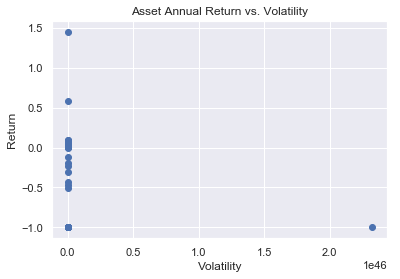

In [4]:
plt.scatter(table['Annual Volatility'], table['Annual Return'])
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Asset Annual Return vs. Volatility')

In [5]:
#Covariance Matrix
equities_MSCI_returns.corr()

,MSCI Australia,MSCI Canada,MSCI China,MSCI EM,MSCI FM,MSCI World,MSCI Germany,MSCI Japan,MSCI UK,MSCI USA
MSCI Australia,1.000000,0.665666,0.688079,0.857241,0.629829,0.664738,0.475195,0.386249,0.560396,0.577290
MSCI Canada,0.665666,1.000000,0.693587,0.843987,0.642479,0.775723,0.515953,0.389540,0.591595,0.748964
MSCI China,0.688079,0.693587,1.000000,0.828423,0.463700,0.689582,0.648896,0.542187,0.654532,0.626189
MSCI EM,0.857241,0.843987,0.828423,1.000000,0.619278,0.853272,0.814314,0.648265,0.805307,0.779103
MSCI FM,0.629829,0.642479,0.463700,0.619278,1.000000,0.624109,0.573399,0.467475,0.649876,0.557807
MSCI World,0.664738,0.775723,0.689582,0.853272,0.624109,1.000000,0.724896,0.677180,0.741618,0.891445
MSCI Germany,0.475195,0.515953,0.648896,0.814314,0.573399,0.724896,1.000000,0.429495,0.560730,0.576495
MSCI Japan,0.386249,0.389540,0.542187,0.648265,0.467475,0.677180,0.429495,1.000000,0.428494,0.384408
MSCI UK,0.560396,0.591595,0.654532,0.805307,0.649876,0.741618,0.560730,0.428494,1.000000,0.600300
MSCI USA,0.577290,0.748964,0.626189,0.779103,0.557807,0.891445,0.576495,0.384408,0.600300,1.000000


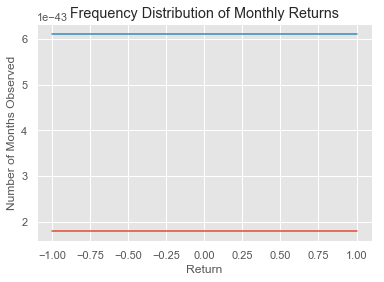

Mean: 1.0236824438297106e+41
Std. Dev.: 2.2334114153089988e+42
Skew: 21.77158930442004
Excess Kurtosis:  472.00210084033625
P-Value: 0.0
The returns are likely not normal.


In [6]:
#Histogram
plt.style.use('ggplot')
u = np.linspace(-1, 1, 500)
series = GSCI_returns['GSCI']
scipy_kernel = gaussian_kde(series)
smoothed_distribution = scipy_kernel.evaluate(u)
normal_distribution = stats.norm.pdf(u, np.mean(series), np.std(series))
plt.plot(u, normal_distribution)
plt.plot(u, smoothed_distribution)
plt.xlabel('Return')
plt.ylabel('Number of Months Observed')
plt.title('Frequency Distribution of Monthly Returns')
plt.show()

print('Mean:', np.mean(series))
print('Std. Dev.:', np.std(series))
print('Skew:', stats.skew(series))
print("Excess Kurtosis: ", stats.kurtosis(series, fisher=True)) #Normal = 0

#Jarque-Bera Normality Test Using S and K (test statistic only asymptotically Chi-squared distributed)
pvalue = jarque_bera(series)[1]
print('P-Value:', pvalue)
if pvalue > 0.05:
    print('The returns are likely normal.')
else:
    print('The returns are likely not normal.')

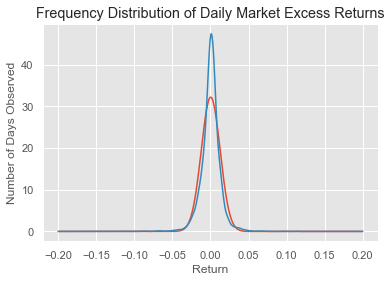

Mean: 0.00029670242352006367
Std. Dev.: 0.012376595824677901
Skew: -0.10758531033580025
Kurtosis:  9.906866877791671
P-Value: 0.0
The returns are likely not normal.


In [7]:
#Histogram
plt.style.use('ggplot')
u = np.linspace(-0.2, 0.2, 500)
series = FF_factor_return['Mkt-RF'].loc['1997-01-02':'2016-12-30']
scipy_kernel = gaussian_kde(series)
smoothed_distribution = scipy_kernel.evaluate(u)
normal_distribution = stats.norm.pdf(u, np.mean(series), np.std(series))
plt.plot(u, normal_distribution)
plt.plot(u, smoothed_distribution)
plt.xlabel('Return')
plt.ylabel('Number of Days Observed')
plt.title('Frequency Distribution of Daily Market Excess Returns')
plt.show()

print('Mean:', np.mean(series))
print('Std. Dev.:', np.std(series))
print('Skew:', stats.skew(series))
print("Kurtosis: ", stats.kurtosis(series, fisher=False)) #Normal = 3

#Jarque-Bera Normality Test Using S and K (test statistic only asymptotically Chi-squared distributed)
pvalue = jarque_bera(series)[1]
print('P-Value:', pvalue)
if pvalue > 0.05:
    print('The returns are likely normal.')
else:
    print('The returns are likely not normal.')

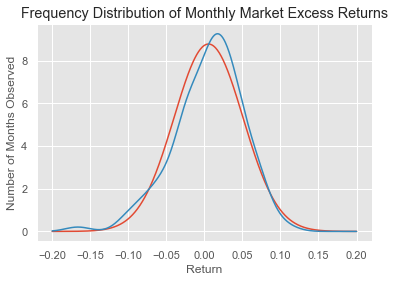

Mean: 0.005483357188584291
Std. Dev.: 0.04538742432872106
Skew: -0.6632027170218371
Kurtosis:  3.966232076712461
P-Value: 1.4201060477247692e-06
The returns are likely not normal.


In [8]:
#Histogram
plt.style.use('ggplot')
u = np.linspace(-0.2, 0.2, 500)
series = daily_to_monthly(FF_factor_return['Mkt-RF'].loc['1997-01-31':'2016-12-30'])
scipy_kernel = gaussian_kde(series)
smoothed_distribution = scipy_kernel.evaluate(u)
normal_distribution = stats.norm.pdf(u, np.mean(series), np.std(series))
plt.plot(u, normal_distribution)
plt.plot(u, smoothed_distribution)
plt.xlabel('Return')
plt.ylabel('Number of Months Observed')
plt.title('Frequency Distribution of Monthly Market Excess Returns')
plt.show()

print('Mean:', np.mean(series))
print('Std. Dev.:', np.std(series))
print('Skew:', stats.skew(series))
print("Kurtosis: ", stats.kurtosis(series, fisher=False)) #Normal = 3

#Jarque-Bera Normality Test Using S and K (test statistic only asymptotically Chi-squared distributed)
pvalue = jarque_bera(series)[1]
print('P-Value:', pvalue)
if pvalue > 0.05:
    print('The returns are likely normal.')
else:
    print('The returns are likely not normal.')

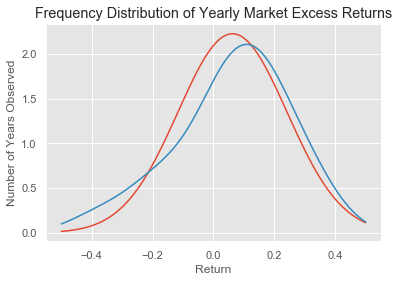

Mean: 0.06241183804890939
Std. Dev.: 0.17923554655666413
Skew: -0.6407982304068452
Kurtosis:  3.007452602012653
P-Value: 0.5043959207009061
The returns are likely normal.


In [9]:
#Histogram
plt.style.use('ggplot')
u = np.linspace(-0.5, 0.5, 500)
series = daily_to_yearly(FF_factor_return['Mkt-RF'].loc['1997-12-31':'2016-12-30'])
scipy_kernel = gaussian_kde(series)
smoothed_distribution = scipy_kernel.evaluate(u)
normal_distribution = stats.norm.pdf(u, np.mean(series), np.std(series))
plt.plot(u, normal_distribution)
plt.plot(u, smoothed_distribution)
plt.xlabel('Return')
plt.ylabel('Number of Years Observed')
plt.title('Frequency Distribution of Yearly Market Excess Returns')
plt.show()

print('Mean:', np.mean(series))
print('Std. Dev.:', np.std(series))
print('Skew:', stats.skew(series))
print("Kurtosis: ", stats.kurtosis(series, fisher=False)) #Normal = 3

#Jarque-Bera Normality Test Using S and K (test statistic only asymptotically Chi-squared distributed)
pvalue = jarque_bera(series)[1]
print('P-Value:', pvalue)
if pvalue > 0.05:
    print('The returns are likely normal.')
else:
    print('The returns are likely not normal.')

In [ ]:
ts = pd.Series(range(10), index = pd.date_range('7/31/2015', freq = 'M', periods = 10))
rng = pd.date_range('1/1/2011', periods=72, freq='H')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
converted = ts.asfreq('45Min', method='pad')
converted.head()